# make sure you install statsmodels with version >= 0.12.1

In [85]:
! conda install statsmodels

# clear the memory

In [1]:
%reset -f

# load Python packages

In [2]:
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import seaborn           as sns
import numpy             as np

from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools   import adfuller

# the usual plot settings we have been doing for several weeks

In [3]:
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
sns.mpl.rc('figure',figsize=(16, 6))

# load data into Python

In [14]:
df = pd.read_excel('ausunemp.xlsx')

In [15]:
df.head()

,Month,Unemployment rate (percentage; source: ABS)
0,1990-01-01,6.7
1,1990-02-01,7.1
2,1990-03-01,6.5
3,1990-04-01,6.3
4,1990-05-01,6.5


# set time index

In [16]:
df.index = pd.date_range(start='1990-01-01', periods=355, freq='M')
df.drop(['Month'], axis=1, inplace=True)

In [17]:
df.head()

,Unemployment rate (percentage; source: ABS)
1990-01-31,6.7
1990-02-28,7.1
1990-03-31,6.5
1990-04-30,6.3
1990-05-31,6.5


# rename your variable

In [18]:
df = df.rename(columns={"Unemployment rate (percentage; source: ABS)": "data"})

In [19]:
df.head()

,data
1990-01-31,6.7
1990-02-28,7.1
1990-03-31,6.5
1990-04-30,6.3
1990-05-31,6.5


# check the time index of the data

In [20]:
df.index

DatetimeIndex(['1990-01-31', '1990-02-28', '1990-03-31', '1990-04-30',
               '1990-05-31', '1990-06-30', '1990-07-31', '1990-08-31',
               '1990-09-30', '1990-10-31',
               ...
               '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31',
               '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31',
               '2019-06-30', '2019-07-31'],
              dtype='datetime64[ns]', length=355, freq='M')

# plot the original and differenced series
## if the series is stationery, the moving average and moving std should be hovering around some constant value

In [21]:
df['z_data'] = (df['data'] - df.data.rolling(window=4).mean()) / df.data.rolling(window=12).std()
df['zp_data'] = df['z_data'] - df['z_data'].shift(1)

def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].scatter(df.index, df.data, color='c', label='raw data')
    ax[0].plot(df.data.rolling(window=4).mean(), color='b', label="moving avergae");
    ax[0].plot(df.data.rolling(window=4).std(), color='r', label="moving std");
    ax[0].legend()

    ax[1].scatter(df.index, df.z_data, color='c', label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=4).mean(), color='b', label="moving aveage");
    ax[1].plot(df.z_data.rolling(window=4).std(), color='r', label="moving std");
    ax[1].legend()

    ax[2].scatter(df.index, df.zp_data, color='c', label="1 lag differenced de-trended data")
    ax[2].plot(df.zp_data.rolling(window=4).mean(), color='b', label="moving average");
    ax[2].plot(df.zp_data.rolling(window=4).std(), color='r', label="moving std");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

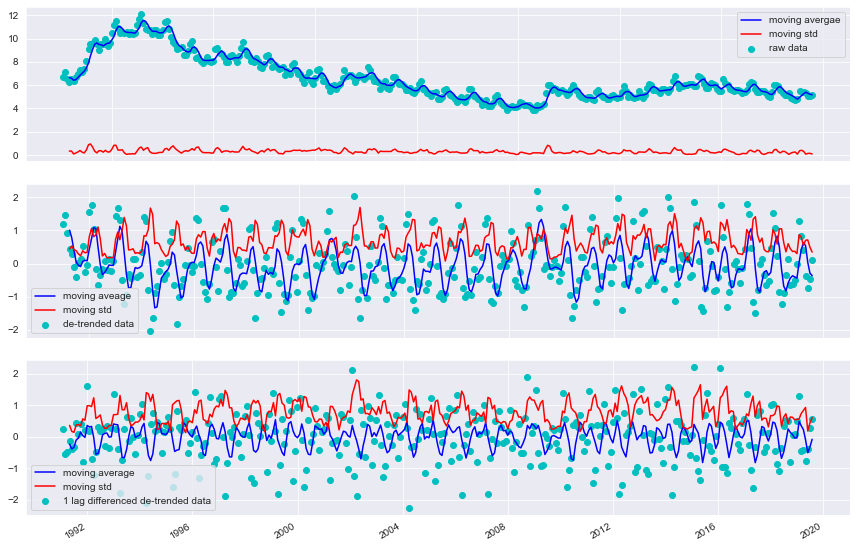

In [22]:
plot_rolling(df)

# ADF test using AIC to auto determine the max lag terms

In [23]:
print(" > Is the data stationary ?")
dftest = adfuller(df.data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
  print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df.z_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
  print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 1-lag differenced de-trended data stationary ?")
dftest = adfuller(df.zp_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
  print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -2.553
P-value = 0.103
Critical values :
	1%: -3.449673193310592 - The data is not stationary with 99% confidence
	5%: -2.8700533746644323 - The data is not stationary with 95% confidence
	10%: -2.5713055939491403 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -4.633
P-value = 0.000
Critical values :
	1%: -3.4505694423906546 - The data is  stationary with 99% confidence
	5%: -2.8704469462727795 - The data is  stationary with 95% confidence
	10%: -2.5715154495841017 - The data is  stationary with 90% confidence

 > Is the 1-lag differenced de-trended data stationary ?
Test statistic = -6.252
P-value = 0.000
Critical values :
	1%: -3.4504451681828194 - The data is  stationary with 99% confidence
	5%: -2.870392380216117 - The data is  stationary with 95% confidence
	10%: -2.571486353732897 - The data is  stationary with 90% confidence


---

# simple exponential smoothing (the level parameter is estimated from the data)

# when to use it
## (1) small sample size
## (2) data with irregular component
## (3) no seasonality or trend

# now let's train your model

In [38]:
# set up your model
model_simple = SimpleExpSmoothing(np.asarray(df['data']), initialization_method="estimated")
# set up the index of your model (which is the time index in your dataframe)
model_simple._index = pd.to_datetime(df.index)

# train the model you just defined
fit_simple  = model_simple.fit(optimized=True)
# report the details of the trained model
fit_simple.summary()

Dep. Variable:,endog,No. Observations:,355
Model:,SimpleExpSmoothing,SSE,45.330
Optimized:,True,AIC,-726.643
Trend:,None,BIC,-718.899
Seasonal:,None,AICC,-726.529
Seasonal Periods:,None,Date:,"Fri, 08 Oct 2021"
Box-Cox:,False,Time:,02:40:23
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,6.6994906,l.0,True


# now let's make forecast for the upcoming 60 time periods

In [39]:
fore_simple = fit_simple.forecast(60)

fore_simple

array([5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2,
       5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2,
       5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2,
       5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2,
       5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2])

# plot the smoothing result alongside with your data and forecast

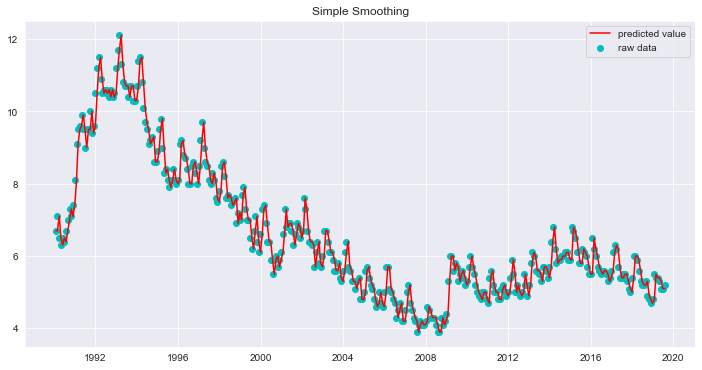

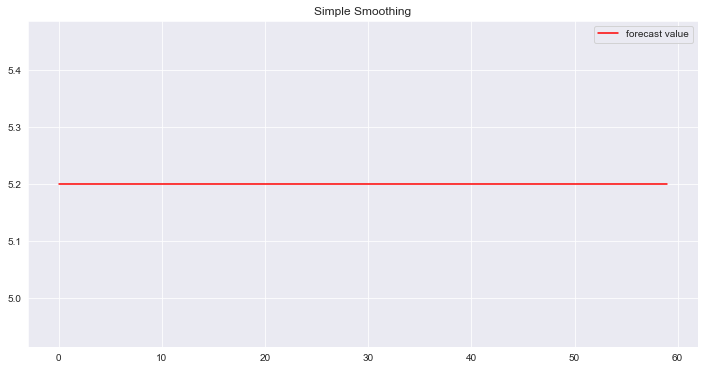

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df.index, fit_simple.fittedvalues, label="predicted value", color='r')
ax.scatter(df.index, df.data, color='c', label='raw data')

plt.title("Simple Smoothing")    
plt.legend();

fig1 = plt.subplots(figsize=(12, 6))
plt.plot(np.arange(0,60), fore_simple, label="forecast value", color='r')
plt.title("Simple Smoothing")    
plt.legend();

---

# Holt’s linear-trend smoothing (the level/trend parameters are estimated from the data)

## when to use it
## (1) small sample size
## (2) data with irregular component and trend
## (3) no seasonality

In [42]:
# set up your model
model_Holt_1 = Holt(np.asarray(df['data']), initialization_method="estimated")
# set up the index of your model (which is the time index in your dataframe)
model_Holt_1._index = pd.to_datetime(df.index)
# train the model you just defined
fit_Holt_1  = model_Holt_1.fit(optimized=True)

# make forecast for the upcoming 60 periods
fore_Holt_1 = fit_Holt_1.forecast(60)

# report the details of the trained model
fit_Holt_1.summary()

Dep. Variable:,endog,No. Observations:,355
Model:,Holt,SSE,45.324
Optimized:,True,AIC,-722.693
Trend:,Additive,BIC,-707.204
Seasonal:,None,AICC,-722.451
Seasonal Periods:,None,Date:,"Fri, 08 Oct 2021"
Box-Cox:,False,Time:,02:44:01
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,5.0152e-13,beta,True


# plot the smoothing result alongside with your data and forecast

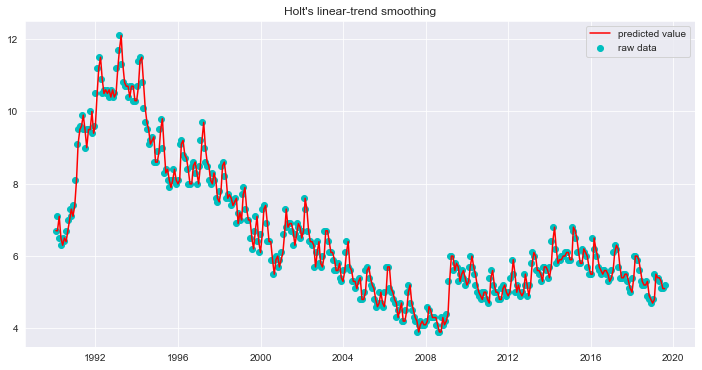

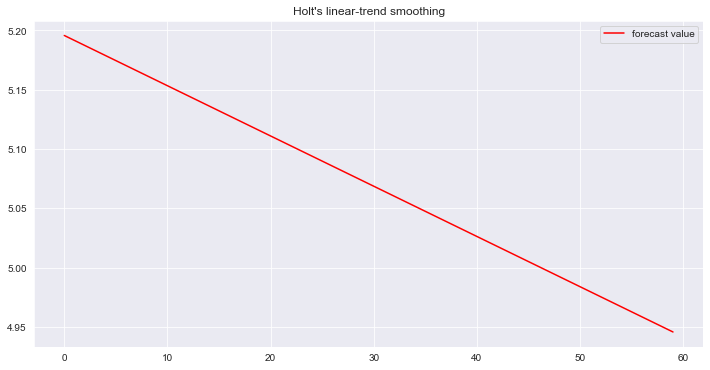

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, fit_Holt_1.fittedvalues, color='r', label='predicted value')
ax.scatter(df.index, df.data, color='c', label='raw data')

plt.title("Holt's linear-trend smoothing")
plt.legend();

fig2 = plt.subplots(figsize=(12, 6))
plt.plot(np.arange(0,60), fore_Holt_1, label="forecast value", color='r')
plt.title("Holt's linear-trend smoothing")    
plt.legend();

---

# Holt's Damped Trend smoothing (everything is estimated from data)

## applid to data with a trend. 

## use the multiplicative version, unless the data has been logged before. 
## otherise, use the additive version

In [44]:
# set up your model: no deamping with damping
model_Holt_2 = ExponentialSmoothing(np.asarray(df['data']), trend='mul', seasonal=None, initialization_method="estimated") 
model_Damp_2 = ExponentialSmoothing(np.asarray(df['data']), trend='mul', seasonal=None, damped_trend = True, initialization_method="estimated")
# set up the index of your model (which is the time index in your dataframe)
model_Holt_2._index = pd.to_datetime(df.index)
model_Damp_2._index = pd.to_datetime(df.index)
# train the model you just defined
fit_Holt_2 = model_Holt_2.fit()
fit_Damp_2 = model_Damp_2.fit()
# report the details of the trained model
fit_Holt_2.summary()

Dep. Variable:,endog,No. Observations:,355
Model:,ExponentialSmoothing,SSE,45.270
Optimized:,True,AIC,-723.111
Trend:,Multiplicative,BIC,-707.622
Seasonal:,None,AICC,-722.870
Seasonal Periods:,None,Date:,"Fri, 08 Oct 2021"
Box-Cox:,False,Time:,02:45:32
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True


In [45]:
fit_Damp_2.summary()

Dep. Variable:,endog,No. Observations:,355
Model:,ExponentialSmoothing,SSE,44.980
Optimized:,True,AIC,-723.394
Trend:,Multiplicative,BIC,-704.034
Seasonal:,None,AICC,-723.071
Seasonal Periods:,None,Date:,"Fri, 08 Oct 2021"
Box-Cox:,False,Time:,02:45:33
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True


In [46]:
# make forecast for the upcoming 60 periods
fore_Holt_2 = fit_Holt_2.forecast(60)
fore_Damp_2 = fit_Damp_2.forecast(60)

# plot the smoothing result alongside with your data and forecast

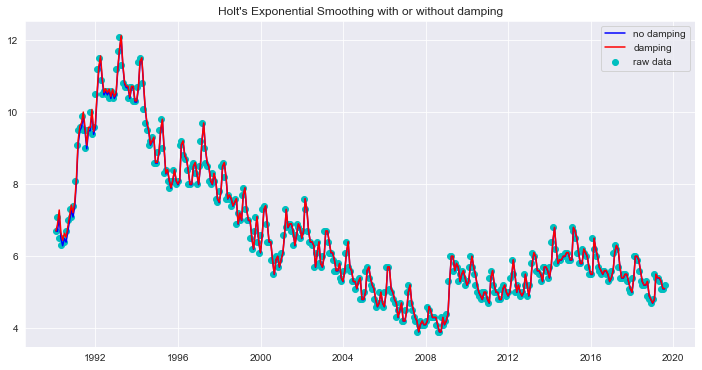

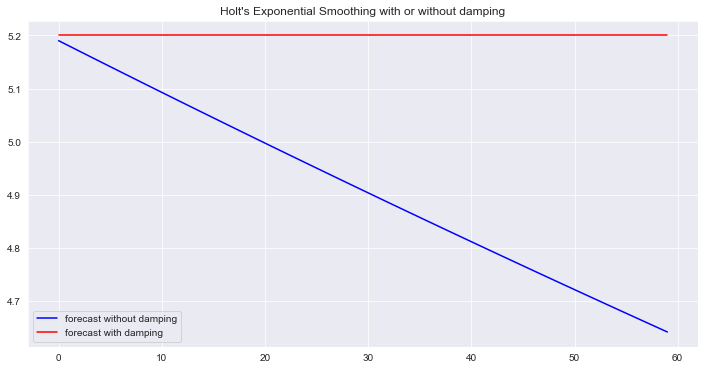

In [47]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(df.index, df.data, c='c', label='raw data')
ax.plot(df.index, fit_Holt_2.fittedvalues, color='b', label="no damping")
ax.plot(df.index, fit_Damp_2.fittedvalues, color='r', label="damping")

plt.title("Holt's Exponential Smoothing with or without damping") 
plt.legend()

fig2 = plt.subplots(figsize=(12, 6))
plt.plot(np.arange(0,60), fore_Holt_2, label="forecast without damping", color='b')
plt.plot(np.arange(0,60), fore_Damp_2, label="forecast with damping", color='r')
plt.title("Holt's Exponential Smoothing with or without damping")    
plt.legend();

# Holt-Winters seasonal smoothing 

In [52]:
# set up your model: no deamping with damping
model_season_Holt = ExponentialSmoothing(np.asarray(df['data']), trend="mul", seasonal="mul", seasonal_periods=12, initialization_method="estimated")
model_season_Damp = ExponentialSmoothing(np.asarray(df['data']), trend="mul", seasonal="mul", seasonal_periods=12, damped_trend=True, initialization_method="estimated")
# set up the index of your model (which is the time index in your dataframe)
model_season_Holt._index = pd.to_datetime(df.index)
model_season_Damp._index = pd.to_datetime(df.index)
# train the model you just defined
fit_season_Holt = model_season_Holt.fit()
fit_season_Damp = model_season_Damp.fit()
# make the forecast for upcoming 60 periods
fore_season_Holt = fit_season_Holt.forecast(60)
fore_season_Damp = fit_season_Damp.forecast(60)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [53]:
# report the details of the trained model : no deamping
fit_season_Holt.summary()

Dep. Variable:,endog,No. Observations:,355
Model:,ExponentialSmoothing,SSE,15.108
Optimized:,True,AIC,-1088.698
Trend:,Multiplicative,BIC,-1026.744
Seasonal:,Multiplicative,AICC,-1086.663
Seasonal Periods:,12,Date:,"Fri, 08 Oct 2021"
Box-Cox:,False,Time:,02:48:45
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6819689,alpha,True
smoothing_trend,0.1328241,beta,True


In [57]:
# report the details of the trained model : with deamping
fit_season_Damp.summary()

Dep. Variable:,endog,No. Observations:,355
Model:,ExponentialSmoothing,SSE,14.311
Optimized:,True,AIC,-1105.934
Trend:,Multiplicative,BIC,-1040.108
Seasonal:,Multiplicative,AICC,-1103.665
Seasonal Periods:,12,Date:,"Fri, 08 Oct 2021"
Box-Cox:,False,Time:,02:49:35
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6857644,alpha,True
smoothing_trend,0.0666912,beta,True


# plot the smoothing result alongside with your data and forecast

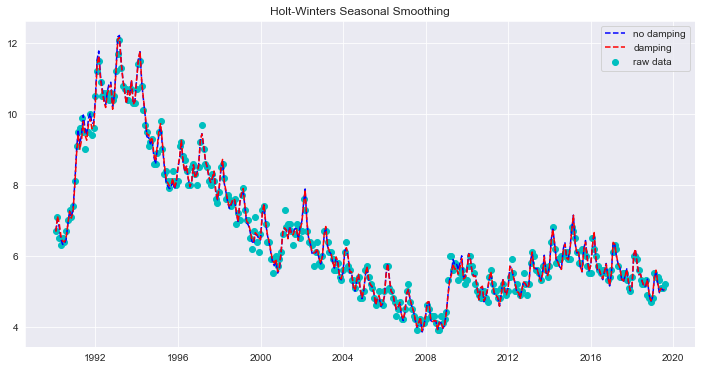

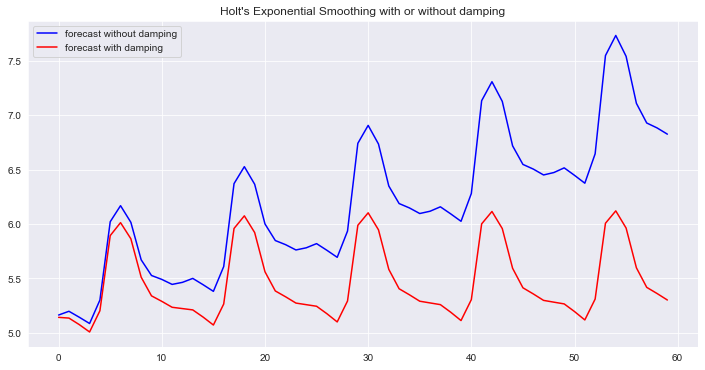

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df.index, df.data, color ='c', label='raw data');
ax.plot(df.index, fit_season_Holt.fittedvalues, linestyle='--', color='b', label="no damping")
ax.plot(df.index, fit_season_Damp.fittedvalues, linestyle='--', color='r', label="damping")
ax.legend();
ax.set_title("Holt-Winters Seasonal Smoothing");

fig2 = plt.subplots(figsize=(12, 6))
plt.plot(np.arange(0,60), fore_season_Holt, label="forecast without damping", color='b')
plt.plot(np.arange(0,60), fore_season_Damp, label="forecast with damping", color='r')
plt.title("Holt's Exponential Smoothing with or without damping")    
plt.legend();

# plot the forecasts from all models in one graph

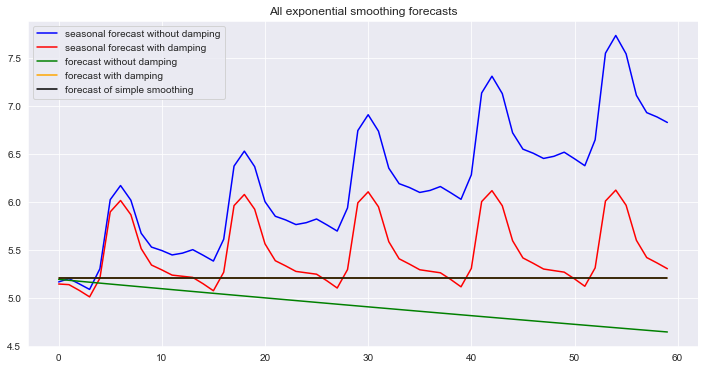

In [56]:
fig3 = plt.subplots(figsize=(12, 6))
plt.plot(np.arange(0,60), fore_season_Holt, label="seasonal forecast without damping", color='b')
plt.plot(np.arange(0,60), fore_season_Damp, label="seasonal forecast with damping"   , color='r')
plt.plot(np.arange(0,60), fore_Holt_2     , label="forecast without damping"       , color='g')
plt.plot(np.arange(0,60), fore_Damp_2     , label="forecast with damping"          , color='orange')
plt.plot(np.arange(0,60), fore_simple     , label="forecast of simple smoothing"     , color='k')
plt.title("All exponential smoothing forecasts")    
plt.legend();

# export code into HTML

In [59]:
!rm -rf W7_Python.html
!jupyter nbconvert --to html W7_Python.ipynb

[NbConvertApp] Converting notebook W7_Python.ipynb to html
[NbConvertApp] Writing 1366929 bytes to W7_Python.html
